# Calculation of control fields for QFT gate on two qubits using L-BFGS-B algorithm

Alexander Pitchford (agp1@aber.ac.uk)

In [1]:
cd /Users/benrosand/oct-qiskit-pulse

/Users/benrosand/oct-qiskit-pulse


### Imports

In [2]:
z%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

SyntaxError: invalid syntax (<ipython-input-2-82aae7c5a02f>, line 1)

In [3]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor, hadamard_transform, basis, cnot
from qutip.qip.algorithms import qft
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen
from src.qutip_helper import convert_qutip_ham
from src.helper import *
from qiskit import IBMQ
from qutip.qip.device import Processor
from qiskit.pulse import Play, SamplePulse

from qiskit.providers.aer.pulse.system_models.hamiltonian_model import HamiltonianModel
from src.three_restructure import *
example_name = 'QFT'

### Defining the physics

Note here that there are two controls acting on each qubit.

In [4]:
# subsystem_list=[0,1]
subsystem_list=[0,1]
IBMQ.load_account()

# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_valencia')
backend.configuration().hamiltonian['vars']
# backend.configuration().hamiltonian['vars']['delta0'] = -3.3

omegad_mult = True

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


\begin{align} \mathcal{H}/\hbar = & \sum_{i=0}^{4}\left(\frac{\omega_{q,i}}{2}(\mathbb{I}-\sigma_i^{z})+\frac{\Delta_{i}}{2}(O_i^2-O_i)+\Omega_{d,i}D_i(t)\sigma_i^{X}\right) \\ & + J_{1,2}(\sigma_{1}^{+}\sigma_{2}^{-}+\sigma_{1}^{-}\sigma_{2}^{+}) + J_{3,4}(\sigma_{3}^{+}\sigma_{4}^{-}+\sigma_{3}^{-}\sigma_{4}^{+}) + J_{0,1}(\sigma_{0}^{+}\sigma_{1}^{-}+\sigma_{0}^{-}\sigma_{1}^{+}) + J_{2,3}(\sigma_{2}^{+}\sigma_{3}^{-}+\sigma_{2}^{-}\sigma_{3}^{+}) \\ & + \Omega_{d,0}(U_{0}^{(0,1)}(t))\sigma_{0}^{X} + \Omega_{d,1}(U_{1}^{(1,0)}(t)+U_{2}^{(1,2)}(t))\sigma_{1}^{X} \\ & + \Omega_{d,2}(U_{3}^{(2,1)}(t)+U_{4}^{(2,3)}(t))\sigma_{2}^{X} + \Omega_{d,3}(U_{6}^{(3,4)}(t)+U_{5}^{(3,2)}(t))\sigma_{3}^{X} \\ & + \Omega_{d,4}(U_{7}^{(4,3)}(t))\sigma_{4}^{X} \\ \end{align}


In [5]:
# For 3 level system
zero_vars = ['wq0', 'wq1']

H_d, H_c = get_hamiltonians(backend, subsystem_list, zero_vars)

U_0 = identity(9)
U_targ = get_cnot()
gate_type = 'cnot'
# H_c.pop(1)
notes = ''
# notes = 'no y control'
# notes = 'def_x on q0'
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
# p_type = 'GAUSSIAN'
DEROTATE = False


# notes += 'zeros: ' + str(zero_vars)

# notes += ', no y control'

# notes += ', omegad * 2'
# H_c = [backend.configuration().hamiltonian['vars']['omegad0'] * q0sigx, backend.configuration().hamiltonian['vars']['omegad0'] * q0sigy]
# ! Don't forget to try omegad0 * 2 or / 2

U0
not using control channels, skippping...
U1
not using control channels, skippping...
U3
not using control channels, skippping...
U2
not using control channels, skippping...
D0
Double check that sigx2 and  sigy2 are right
D1
Double check that sigx2 and  sigy2 are right
/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# For 2 level system
two_level=False
if two_level:
    notes += ', 2 levels'
    omegad0 = backend.configuration().hamiltonian['vars']['omegad0']
    omegad1 = backend.configuration().hamiltonian['vars']['omegad1']

    q1sigx = tensor(sigmax(), identity(2))
    q1sigy = tensor(sigmay(), identity(2))
    q0sigx = tensor(identity(2), sigmax())
    q0sigy = tensor(identity(2), sigmay())


    # q0sigy[]

    H_c = [omegad0 * q0sigx, omegad0 * q0sigy, omegad1 * q1sigx, omegad1 * q1sigy]
    # H_c = [omegad0 * sigmax(), omegad0 * sigmay()]
    U_0 = tensor(identity(2), identity(2))
    # U_0 = identity(2)
    H_d = U_0 * 0
    # U_targ = hadamard_transform(1)
    U_targ = cnot()

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
n_ctrls = len(H_c)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
H_d

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.00000000e-03  0.00000000e+00  1.39062413e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.97004358e+00  0.00000000e+00
   1.96663950e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.39062413e-02  0.00000000e+00  1.00000000e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.96663950e-02  0.00000000e+00
   2.00000000e-03  0.00000000e+00  1.96663950e-02  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.96904358e+00  0.00000000e+00  2.78124825e-02
   0.00000000e+00]
 [ 0

Multiple total evolution times will be tried. Using this approach, the minimum evolution time required to achieve the target fidelity could be determined (iteratively).

Note that the timeslot duration dt is fixed, and so the number of timeslots depends on the evo_time

In [9]:
# Duration of each timeslot
dt = backend.configuration().dt * 1e9
# dt = 0.02
# n_ts_00 = []#[16,32]
n_ts_0 = list(np.arange(64,160, 32))
n_ts_list = list(np.arange(160,1600,160))
n_ts_list = n_ts_0 + n_ts_list
# n_ts_list = [160]#, 480, 560,640]
evo_times = [dt * n for n in n_ts_list]
# List of evolution times to try
# evo_times = [1, 3, 6]
n_evo_times = len(evo_times)
evo_time = evo_times[0]
n_ts = int(float(evo_time) / dt)
#Empty list that will hold the results for each evolution time
# results = list()
n_ts_list

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[64, 96, 128, 160, 320, 480, 640, 800, 960, 1120, 1280, 1440]

### Set the conditions which will cause the pulse optimisation to terminate

### Set the initial pulse type

Here the linear initial pulse type is used, simply because it results in smooth final pulses

### Give an extension for output files

In [10]:
#Set to None to suppress output files
# f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)
f_ext = None

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create the optimiser objects

Here is the main difference between this and the Hadamard example. In this case we use a different pulseoptim function that just creates the objects that can be used to set the physics and configure the optimisation algorithm. This gives greater flexibility (shown here by seting different initial pulse parameters for each control) and is also more efficient when running multiple optimisations on the same system.

In [11]:
# Fidelity error target
fid_err_targ = 1e-30
# Maximum iterations for the optisation algorithm
max_iter = 2000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-30

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
H_d

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.00000000e-03  0.00000000e+00  1.39062413e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.97004358e+00  0.00000000e+00
   1.96663950e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.39062413e-02  0.00000000e+00  1.00000000e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.96663950e-02  0.00000000e+00
   2.00000000e-03  0.00000000e+00  1.96663950e-02  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.96904358e+00  0.00000000e+00  2.78124825e-02
   0.00000000e+00]
 [ 0

In [13]:
p_type='GAUSSIAN'
optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                amp_lbound=-.7, amp_ubound=.7, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                optim_method='fmin_l_bfgs_b',
                method_params={'max_metric_corr':20, 'accuracy_factor':1e8},
                dyn_type='UNIT', 
                fid_params={'phase_option':'PSU'},
                init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True, alg='GRAPE')

# **** get handles to the other objects ****
optim.test_out_files = 0
dyn = optim.dynamics
dyn.test_out_files = 0
p_gen = optim.pulse_generator
results = run_optimizer(optim, dt, n_evo_times,dyn, p_type, n_ts, len(H_c), f_ext, evo_time, evo_times, p_gen)


7j    1.11815936e-02+0.05487548j
   1.03919520e-02-0.0167888j   2.73533688e-02-0.00591146j
   3.08964350e-02+0.00156918j  7.30586621e-01+0.66871061j
   3.95232853e-04-0.10121823j  1.63451591e-03-0.00404858j
   3.56113894e-03+0.02395442j]
 [-1.52464365e-02+0.01042866j  3.63405663e-02-0.08059178j
   1.37636660e-02+0.0303066j   1.27510464e-02-0.00262555j
  -2.77566270e-02+0.02807433j  1.02737103e-01-0.01099054j
   7.64739790e-01+0.62301388j -1.03504522e-02+0.06804359j
   7.07262283e-03-0.02389717j]
 [ 3.63080295e-02-0.08580532j  1.24922352e-02+0.07378513j
  -7.88520872e-03-0.09156179j  6.24303705e-02-0.04308498j
   1.57330708e-02+0.02730886j -2.15402309e-03+0.00310623j
  -5.40530513e-02+0.03037436j  7.90950975e-01+0.58334331j
   2.19770946e-02+0.01707295j]
 [-3.36487670e-02+0.00988385j  3.16909111e-02-0.02266485j
   3.25828091e-03-0.07771157j -5.54408186e-02+0.04335539j
   2.62318355e-02-0.03730859j -2.41403883e-02-0.00408068j
   2.79778980e-02-0.00877237j -2.06447609e-02-0.01223762j
   7

### Optimise the pulse for each of the different evolution times

Here a loop is used to perform the optimisation for each of the evo_times given in the list above. The first optimisation is completed using the timeslot parameters passed when the optimisation objects are created. For the subsequent runs, the Dynamics object 'dyn' is used to set the timeslot parameters before the initial pulses are generated and optimisation is completed. Note that using this method, the dyn.initialize_controls method must be called with an array of the initial amplitudes before the optim.run_optimization method is called.

In [14]:
evo = results[4].evo_full_final
evo.tidyup(1e-3)
# len(H_c)
# H_c[4]


/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.46011106-0.86944881j  0.15473264+0.08131432j  0.01875424-0.00383444j
   0.0025787 +0.01010451j  0.00916782-0.00287285j  0.00221396-0.00903894j
   0.01444466-0.01596386j -0.01305779-0.00904251j  0.01108694-0.0175958j ]
 [ 0.15643815+0.07876577j  0.43785825-0.88069998j  0.00819784+0.01218561j
   0.00879297+0.00925489j  0.02114295-0.00726734j -0.01451249-0.00951196j
  -0.02206713-0.00107717j  0.00851019-0.00350473j  0.        -0.01477129j]
 [ 0.00517963+0.02077285j  0.01202689+0.0029788j   0.58114162-0.81253184j
  -0.00132371-0.01348207j  0.00264199-0.02068865j -0.01843538+0.j
   0.00280923+0.00197849j -0.00537704+0.00180773j -0.01719971+0.01249463j]
 [-0.00198301+0.0051487j   0.00338312+0.01637613j -0.0170597 +0.01365039j
  -0.27545793-0.21360683j  0.55617963-0.75329519j -0.02114724+0.00334827j
   0.00213639+0.0070459j   0.00100211+0.01488738j  0.00407152+0.01289782j]
 [ 0.01251639+0.j        

In [15]:
U_targ

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]

### Plot the initial and final amplitudes

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


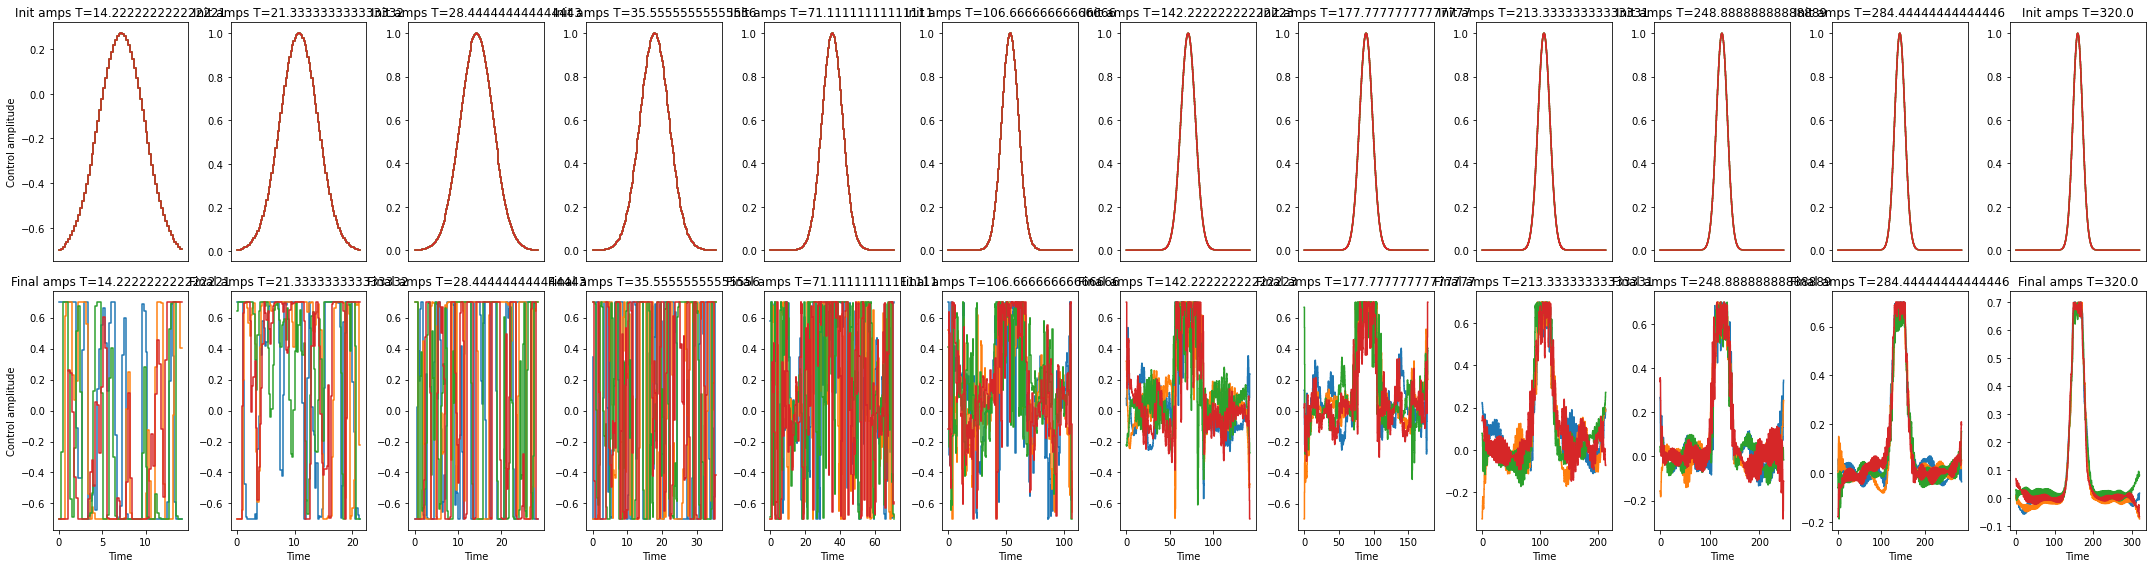

In [16]:
plot_results(n_evo_times,n_ctrls,results, evo_times)

### Versions

In [17]:
pulse_seq = results[0].final_amps
U_targ
run_qutip_sim(subsystem_list,backend,results[4].final_amps,H_c,H_d).states[-1]

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.46019284-0.86943196j]
 [ 0.15633009+0.07874513j]
 [ 0.00503783+0.02061991j]
 [-0.00194898+0.00514511j]
 [ 0.01245133+0.j        ]
 [-0.00397497+0.00457982j]
 [ 0.        +0.01491199j]
 [-0.01946648-0.00480467j]
 [-0.01193461+0.01516486j]]

### Run QuTip pulse simulation

In [18]:
# init_x = backend.defaults().instruction_schedule_map.get('x',[0])
# init_x
# run_qutip_sim(subsystem_list, backend, pulse_seq, H_c, H_d)
# def_seq = init_x.instructions[0]
# def_seq=def_seq[1].pulse.get_waveform().samples

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# results[0].final_amps

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create Channels and convert qoc pulses to Qiskit pulses

In [20]:
# Create the base schedule

# schedule = def_cx
# schedule.draw(plot_range=[0, 1000])
qoc_programs = [generate_qiskit_program(result.final_amps, backend, derotate_flag=DEROTATE) for result in results]


/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Run the assembled pulse schedule

In [21]:
jobs = []
for i,program in enumerate(qoc_programs):
    cur_job = backend.run(program)
    jobs.append(cur_job)
    pulse_steps = n_ts_list[i]
    cur_job.update_tags(['QOC', 'n_ts=' + str(pulse_steps), p_type])

# jobs.append(def_job)
# job = backend.run(frequency_sweep_program)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
U_targ

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]

In [23]:
# def_job=backend.run(generate_qiskit_program(def_seq,backend, True))
# def_job.update_tags(['builtin'])
from src.helper import qubit_distribution
qubit_distribution(jobs[0].result().get_counts())

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: {0: 1015, 1: 9},
 1: {0: 1021, 1: 3},
 2: {0: 1001, 1: 23},
 3: {0: 296, 1: 728},
 4: {0: 615, 1: 409}}

In [24]:

# job_monitor(jobs[0])
from qiskit.tools.monitor import job_monitor
job_monitor(jobs[-1])

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Job Status: job has successfully run


In [25]:
last_qub = backend.configuration().n_qubits

acc = {a:0 for a in n_ts_list}
for i,job in enumerate(jobs):
    n_ts = n_ts_list[i]
    cur_acc = qubit_distribution(job.result().get_counts())[last_qub-1][1]/1024
    acc[n_ts] = cur_acc

acc1 = {a:0 for a in n_ts_list}
for i,job in enumerate(jobs):
    n_ts = n_ts_list[i]
    cur_acc = qubit_distribution(job.result().get_counts())[last_qub-2][1]/1024
    acc1[n_ts] = cur_acc


/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:

acc

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{64: 0.3994140625,
 96: 0.5322265625,
 128: 0.7080078125,
 160: 0.6494140625,
 320: 0.181640625,
 480: 0.787109375,
 640: 0.802734375,
 800: 0.89453125,
 960: 0.74609375,
 1120: 0.12109375,
 1280: 0.326171875,
 1440: 0.353515625}

In [27]:
# f_csv='results.csv'
# write_results(f_csv, acc, p_type, backend, 'X')
# notes = '2 levels, first section cnot 1-0 qubit 0'

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# gate_type = 'hadamrd'
# notes = 'no y control'
# notes = ''
if DEROTATE:
    notes+= 'derotated'
# f = open(f_csv,'wb')
# acc['p_type'] = p_type
# acc['backend'] = backend.name()
# acc['gate_type'/] = gate_type
# w = csv.DictWriter(f,acc.keys())
# w.writerow(acc)
# f.close()

import csv
# notes = '2 levels'

with open('2q_results.csv', 'a', newline='') as csvfile:
    fieldnames = ['n_ts', 'frac_0', 'frac_1', 'p_type', 'backend', 'gate_type', 'delta0', 'notes']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # writer.writeheader() 
    for row in acc.keys():
        out_dict = {'n_ts': row, 'frac_0' : acc[row], 'frac_1' : acc1[row], 'p_type': p_type, 'backend' : backend.name(),
                    'gate_type' : gate_type, 'delta0' : backend.configuration().hamiltonian['vars']['delta0'], 'notes' : notes}
        writer.writerow(out_dict)



/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
jobs[0].result()

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
from qiskit.circuit.library import HGate, U2Gate
import qiskit
circ = qiskit.QuantumCircuit(1,1)
circ.h(0)
transp_circ = qiskit.transpile(circ, backend=backend)
transp_circ.data[0]
# backend.defaults().instruction_schedule_map.get(U2Gate())

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(<qiskit.circuit.library.standard_gates.u2.U2Gate at 0x7fbee948e460>,
 [Qubit(QuantumRegister(5, 'q'), 0)],
 [])